In [3]:
import numpy as np
from ambiance import Atmosphere
import json
import matplotlib.pyplot as plt

In [4]:
class units_class:
    def __init__():
        return

    def ft2m(ft):
        return 0.3048 * ft


    def lbf2n(lbf):
        return 4.4482 * lbf


    def lbm2kg(lbm):
        return 0.4536 * lbm


    def mi2m(mi):
        return  1609 * mi


    def in2m(inches):
        return 0.0254 * inches


    def knot2ms(knot):
        return 0.514 * knot


    def kgf2n(kgf):
        return 9.807 * kgf


    def slug2kg(slug):
        return 14.5939 * slug


    def knot2fts(knot):
        return 1.47 * knot


    def psi2Pa(psi):
        return 6894.76 * psi

    def hp2Watt(hp):
        return 745.69 * hp

## Definções basicas do projeto

Para a aeronave desenvolvida será usada  como  base de dimensionamento a velocidade de cruzeiro, com missão principal sendo a long range ferry, com desvio para a alternativa.

https://docs.google.com/presentation/d/13Bx6JYLn4xWmHGJNFM41O5MWNgtxeQgXbuCpnetwMNY/edit?usp=sharing

In [5]:
units = units_class

aircraft = {
   'definitions': {
  'MTOW': units.lbm2kg(19000), # Kg, assuming MTOW given by FAR23
  'V_cruise': units.knot2ms(230), # m/s, assuming CAS
  'W_empty/W': 0.6, # from database
  'W_crew': 200, # 2 pilots
  'operational ceiling': units.ft2m(25000),
   },
  'engine': {
  'power': units.hp2Watt(1600)
            },
  'wing': {},
  'ht': {},
  'vt': {},
  'fus': {},
  'landing gear': {},
}

In [6]:
# Cálculo do alcance baseado no MTOW a partir da database
range = 0.0854*aircraft['definitions']["MTOW"] + 461
print(f'Range previsto pelo database: {range} nm') # ~ 1100 nm


g = 9.81
rho_SL = 1.225 # Densidade do ar a nível do mar

# Perfil da missão
missao = {
    "Perfil" : ['Take off','Ascending','Cruise_1','Descending','Loitter','Cruise_2','Landing'],
    "Range_1" : units.mi2m(range),
    "Range_2" : units.mi2m(100),
    "Loitter_time" : 20 * 60
}

aircraft['missao'] = missao

Range previsto pelo database: 1197.01136 nm


### Calculos de Estimativa de Performance Inicial

In [7]:
# Calculo de peso vazio
aircraft['definitions']["W_empty"] = aircraft['definitions']["W_empty/W"] * aircraft['definitions']["MTOW"]
print(f'Peso vazio: {aircraft["definitions"]["W_empty"]}')

# Estimativa de carga alar, via linearização dos dados do banco de dados. É dada por Kg de MTOW/ Área de asa; deve ser convertido em N

aircraft['definitions']["wing_load"] = (0.00846 * aircraft['definitions']["MTOW"] + 121)*g
print(f'Carga alar: {aircraft["definitions"]["wing_load"]:.0f}')

# Projetando área para condição de cruzeiro, com consumo de combustível equivalente a 5% do peso total
aircraft['wing']["S"] = 0.95*aircraft["definitions"]["MTOW"] * g / aircraft["definitions"]["wing_load"]
print(f'Área de asa: {aircraft["wing"]["S"]:.1f}')

# Definindo Cl para condição de cruzeiro
aircraft["definitions"]["Cl cruise"] = aircraft["definitions"]["wing_load"] / ( 0.5 * rho_SL * (aircraft["definitions"]["V_cruise"]**2 ) )
print(f'Cl de cruzeiro a nível do mar: {aircraft["definitions"]["Cl cruise"]:.2f}')

# Estimativa do empuxo necessário. Assume-se que, em cruzeiro, usa-se 65% da potência
# máxima do motor; eficiência da hélice de 80%; cálculo a nível do mar para projeto conceitual
power_cruise = 0.65 * aircraft["engine"]["power"]
eta = 0.65

aircraft['engine']["thrust cruise"] =  eta * power_cruise/ aircraft["definitions"]["V_cruise"]
aircraft["definitions"]["Thrust_to_weight"] =  aircraft["engine"]["thrust cruise"]/(aircraft["definitions"]["MTOW"]*g)
print(f'Empuxo do motor: {aircraft["engine"]["thrust cruise"]:.2f}')

aircraft["definitions"]["Cd cruise"] =  aircraft["engine"]["thrust cruise"]/(0.5 * rho_SL * (aircraft["definitions"]["V_cruise"]**2) * aircraft["wing"]["S"])
print(f'Cd de cruzeiro a nível do mar: {aircraft["definitions"]["Cd cruise"]:.4f}')
print(f'L/D de cruzeiro a nível do mar: {aircraft["definitions"]["Cl cruise"]/aircraft["definitions"]["Cd cruise"]:.2f}')

# Calculo do SFC em cruise e loiter a partir de Raymer
aircraft["engine"]['SFC_cruise'] = 0.5 * aircraft["definitions"]['V_cruise'] / (units.hp2Watt(550) * 0.8)
aircraft["engine"]['SFC_loiter'] = 0.6 * aircraft["definitions"]['V_cruise'] / (units.hp2Watt(550) * 0.8)
print(f'Consumo cruise : {aircraft["engine"]["SFC_cruise"]:e}')
print(f'Consumo loiter : {aircraft["engine"]["SFC_loiter"]:e}')

# Calculo de stall
aircraft["definitions"]['V_stall'] = np.sqrt(2*aircraft["definitions"]["MTOW"]*g/(rho_SL * aircraft['wing']['S'] * 2))
print(f"Vel. Stall : {aircraft['definitions']['V_stall']}")


Peso vazio: 5171.04
Carga alar: 1902
Área de asa: 42.2
Cl de cruzeiro a nível do mar: 0.22
Empuxo do motor: 4263.97
Cd de cruzeiro a nível do mar: 0.0118
L/D de cruzeiro a nível do mar: 18.84
Consumo cruise : 1.801565e-04
Consumo loiter : 2.161878e-04
Vel. Stall : 40.43026829075338


### Estimativa de Peso

#### Metodo do Raymer

In [8]:
def first_weight_estimate(aircraft: dict) -> float :
    frac_weight = 1
    fracs = {
        'Take off':0.97,
        'Ascending':0.987,
        'Cruise_1':np.exp(-aircraft['missao']['Range_1'] * aircraft["engine"]["SFC_cruise"]/(aircraft["definitions"]['V_cruise'] * (aircraft["definitions"]["Cl cruise"]/aircraft["definitions"]["Cd cruise"]))),
        'Cruise_2':np.exp(-aircraft['missao']['Range_2'] * aircraft["engine"]["SFC_cruise"]/(aircraft["definitions"]['V_cruise'] * (aircraft["definitions"]["Cl cruise"]/aircraft["definitions"]["Cd cruise"]))),
        'Descending': 1,
        'Loitter': np.exp(-aircraft['missao']['Loitter_time'] * aircraft['engine']['SFC_loiter']/(aircraft["definitions"]["Cl cruise"]/aircraft["definitions"]["Cd cruise"])),
        'Landing': 0.995
    }

    print(fracs)

    for leg in aircraft['missao']['Perfil']:
        frac_weight = frac_weight * fracs[leg]

    return frac_weight

wf_frac = 1 - first_weight_estimate(aircraft)

print(wf_frac)

print(f'wf/w0= {wf_frac}')
print(f'wf = {wf_frac*aircraft["definitions"]["MTOW"]}')
print(f'vol = {wf_frac*aircraft["definitions"]["MTOW"]/0.72}')

w_pay = aircraft["definitions"]['MTOW'] * (1 - wf_frac - aircraft["definitions"]['W_empty/W']) - aircraft["definitions"]['W_crew']
print(f'Payload: {w_pay}')

{'Take off': 0.97, 'Ascending': 0.987, 'Cruise_1': 0.855717833036055, 'Cruise_2': 0.9870673858406859, 'Descending': 1, 'Loitter': 0.9863220797771163, 'Landing': 0.995}
0.20638821544149977
wf/w0= 0.20638821544149977
wf = 1778.7361959610216
vol = 2470.4669388347525
Payload: 1468.6238040389785


### Definição Áreas de Empenagem

Estimativas baseadas e tendencia de Ht e Vt vs. Peso total


In [9]:
def estimate_aerodynamic_areas(aircraft):
    '''
    Estimate areas of aerodynamic surfaces based on the correlation between MTOW and areas of the cargo database
    '''
    # Parameter = MTOW

    x = aircraft['definitions']['MTOW']

    # horizontal tail

    aircraft['ht']['S'] = 4.3E-04*x + 6.03
    aircraft['ht']['S_elevator'] = 3.41E-04*x + 1.16

    aircraft['vt']['S'] = 4.77E-04*x + 2.57
    aircraft['vt']['S_rudder'] = 1.19E-04*x + 1.65

    aircraft['wing']['S_flap'] = 4.43E-04*x + 0.822
    aircraft['wing']['S_aileron'] = 1.8E-04*x + 1.63

    return aircraft

aircraft = estimate_aerodynamic_areas(aircraft)

print(f"S_ref: {aircraft['wing']['S']:.3f}")
print(f"S_Ht: {aircraft['ht']['S']:.3f}")
print(f"S_profundor: {aircraft['ht']['S_elevator']:.3f}")
print(f"S_Vt: {aircraft['vt']['S']:.3f}")
print(f"S_leme: {aircraft['vt']['S_rudder']:.3f}")
print(f"S_flap: {aircraft['wing']['S_flap']:.3f}")
print(f"S_aileron: {aircraft['wing']['S_aileron']:.3f}")

S_ref: 42.223
S_Ht: 9.736
S_profundor: 4.099
S_Vt: 6.681
S_leme: 2.676
S_flap: 4.640
S_aileron: 3.181


In [10]:
print(f"""S_ref: {aircraft['wing']['S']:.3f}
S_Ht: {aircraft['ht']['S']:.3f}
S_profundor: {aircraft['ht']['S_elevator']:.3f}
S_Vt: {aircraft['vt']['S']:.3f}
S_leme: {aircraft['vt']['S_rudder']:.3f}
S_flap: {aircraft['wing']['S_flap']:.3f}
S_aileron: {aircraft['wing']['S_aileron']:.3f}
""")

S_ref: 42.223
S_Ht: 9.736
S_profundor: 4.099
S_Vt: 6.681
S_leme: 2.676
S_flap: 4.640
S_aileron: 3.181



Antes de seguir para a próxima seção, acrescentam-se medidas geométricas, materiais e porcentagem de corda em regime laminar a cada um dos componentes.

As medidas geométricas adicionais são obtidas por meio do CAD da aeronave, que foi obtido por meio da correlação entre dados do database, das áreas estimadas e ajustes de engenharia.

Para os materiais, assume-se alumínio aeroespacial.

Para a porcentagem de corda em regime laminar, utiliza-se a tabela () do livro do Roskam.

In [11]:
wing_param = {
    'b': 21,
    'CMA': 1.965,
    'S_wet': 84.4,
    'Percent_laminar': 0.1,
    'sweep': 0,
    'hinge': False,
    'thickness': 0.1, #provisório
    'material': "Aerospace aluminum", # Dever ser compativel com o arquivo weight_estimation_data.json
}

ht_param = {
    'b': 6.5,
    'CMA': 1.491,
    'S_wet': 18.4,
    'Percent_laminar': 0.1,
    'sweep': 0,
    'hinge': True,
    'thickness': 0.1, #provisório
    'material': "Aerospace aluminum", # Dever ser compativel com o arquivo weight_estimation_data.json
}

vt_param = {
    'b': 2.75,
    'CMA': 2.156,
    'S_wet': 12.3,
    'Percent_laminar': 0.1,
    'sweep': 20,
    'hinge': True,
    'thickness': 0.1, #provisório
    'material': "Aerospace aluminum", # Dever ser compativel com o arquivo weight_estimation_data.json
}

fus_param = {
    'length': 18,
    'S_wet': 95.9,
    'diameter': 1.6,
    'Percent_laminar': 0,
    'material': "Aerospace aluminum", # Dever ser compativel com o arquivo weight_estimation_data.json
}

aircraft['wing'].update(wing_param)
aircraft['ht'].update(ht_param)
aircraft['vt'].update(vt_param)
aircraft['fus'].update(fus_param)

for key, value in aircraft.items():
    print(f'{key} = {value}\n')

definitions = {'MTOW': 8618.4, 'V_cruise': 118.22, 'W_empty/W': 0.6, 'W_crew': 200, 'operational ceiling': 7620.0, 'W_empty': 5171.04, 'wing_load': 1902.27342384, 'Cl cruise': 0.22222091806664124, 'Thrust_to_weight': 0.05043341839359266, 'Cd cruise': 0.011797221617540201, 'V_stall': 40.43026829075338}

engine = {'power': 1193104.0, 'thrust cruise': 4263.969209947555, 'SFC_cruise': 0.0001801565115408669, 'SFC_loiter': 0.0002161878138490403}

wing = {'S': 42.22273086161542, 'S_flap': 4.6399512, 'S_aileron': 3.181312, 'b': 21, 'CMA': 1.965, 'S_wet': 84.4, 'Percent_laminar': 0.1, 'sweep': 0, 'hinge': False, 'thickness': 0.1, 'material': 'Aerospace aluminum'}

ht = {'S': 9.735911999999999, 'S_elevator': 4.0988744, 'b': 6.5, 'CMA': 1.491, 'S_wet': 18.4, 'Percent_laminar': 0.1, 'sweep': 0, 'hinge': True, 'thickness': 0.1, 'material': 'Aerospace aluminum'}

vt = {'S': 6.6809768, 'S_rudder': 2.6755896, 'b': 2.75, 'CMA': 2.156, 'S_wet': 12.3, 'Percent_laminar': 0.1, 'sweep': 20, 'hinge': True, '

# Estimativa de arrasto

## Arrasto parasita

São propostas duas metodologias para estimá-lo.

1 - Método de arrasto de fricção equivalente  

A primeira envolve uma abordagem parametrizada, segundo a expressão:

$C_{D_0} = C_{f_c} \dfrac{S_{wet}}{S_{ref}}$

Ela é válida para regime subsônico, na qual é assumido que o arrasto de fricção é muito superior ao arrasto de pressão devido à separação da camada limite.

Para tanto, conforme a tabela () do livro de Stinton, adota-se $C_f = 0.0026$, que corresponde a uma aeronave de transporte civil. Este coeficiente parametrizado é função somente do tipo de aeronave, e compõe tanto o arrasto de fricção quanto o arrasto de pressão.

In [12]:
Cf = 0.0026
Swet_Sref = 5
Cd0_carteado = Cf * Swet_Sref
Cd0_carteado

0.013

Recalculando, já empregando a área molhada calculada no CAD:

In [13]:
S_wet_total = 0

for key, value in aircraft.items():
    if 'S_wet' in value:
        print(f'Razão de área molhada por área de referência da {key} é {aircraft[key]["S_wet"]/aircraft["wing"]["S"]:.4f}')
        S_wet_total = S_wet_total + aircraft[key]['S_wet']

Cd0_menos_carteado = Cf * S_wet_total/aircraft['wing']['S']
print(f'Arrasto parasita total via valor parametrizado do Raymer = {Cd0_menos_carteado:.4f}')

Razão de área molhada por área de referência da wing é 1.9989
Razão de área molhada por área de referência da ht é 0.4358
Razão de área molhada por área de referência da vt é 0.2913
Razão de área molhada por área de referência da fus é 2.2713
Arrasto parasita total via valor parametrizado do Raymer = 0.0130


2 - Método de análise por componentes

Esta metodologia busca medir a contribuição de cada componente da aeronave para o arrasto parasita total. Compõe-se das contribuições do coeficiente de arrasto de fricção calculado para uma placa plana $C_f$; de uma estimativa de arrasto de pressão devido à separação da camada limite, dada pelo fator de forma $FF$; os arrastos de interferência entre componentes, dados pelo parâmetro $Q$; todos os termos multiplicados pela área molhada $S_{wet}$.

Para casos especiais, como trens de pouso não retráteis, flaps, protuberâncias e descontinuidades, soma-se estimativas destes componentes ao somatório de produtos anteriormente citado. Sendo assim, a expressão é dada por

$C_{D_0} = \dfrac{\sum(C_{f_c} FF_c Q_c S_{wet_c})}{S_{ref}} + C_{D_{misc}} + C_{D_{L\&P}}$

Esta expressão é válida para regime subsônico. Para supersônico, estima-se o arrasto de fricção e soma-se as contribuições de arrasto de onda a partir da relação de distribuições de volume da aeronave. Para transônico, é tomada uma interpolação entre os regimes.

Os cálculos de cada um dos fatores desta expressão são discorridos a seguir.

## Arrasto de fricção via placa plana

Tudo parte da premissa de encontrar uma estimativa do compromisso entre os tipos de regime de escoamento, laminar e turbulento. Quanto maior a porcentagem de escoamento turbulento, maior a proporção de arrasto de fricção. Por outro lado, a camada limite tende a se separar mais taridamente, reduzindo o arrasto de pressão. O compromisso entre ambos é essencial para um projeto aerodinâmico otimizado.

A nível conceitual, assumem-se porcentagens do comprimento característico de cada componente que ainda estejam sob regime laminar. Para aviação geral, com aeronaves feitas de metal, sem grandes cuidados com rebites ou descontinuidades, considera-se, baseado na tabela 12.4 do Raymer, que todo o escoamento sobre a fuselagem é turbulento, e cerca de 10% de asa e empenagens é laminar.

Para região laminar, o coeficiente de fricção é dado por:

$C_f = \dfrac{1.328}{\sqrt{Re}}$

Já na região turbulenta:

$C_f = \dfrac{0.455}{(log_{10}Re)^{2.58}(1+0.144M^2)^{0.65}}$

Para considerar o efeito de rugosidade das superfícies, verifica-se também o Reynolds de *cutoff*, valor a partir do qual a rugosidade passa a aumentar consideravelmente a contribuição do arrasto de fricção, de forma que este valor de corte é adotado ao invés do Reynolds real. Ele é dado, para regimes subsônicos, por:

$Re_{cutoff} = 38.21 (l/k)^{1.053}$

Baseado nos valores de $C_f$ calculados, adota-se os valores de proporção entre lmainar e turbulento, para chegar aos valores finais de cada componente.





In [14]:
def compute_mu(T):
    mu0 = 1.7894e-5
    T0 = 273.15
    S = 110.4

    return mu0 * (T / T0) ** (3/2) * (T0 + S) / (T + S)

def Re_cutoff(l):

    # Para pintura em alumínio sem tratamento superficial

    k = 1.015e-5

    return 38.21 * (l/k)**(1.053)


def Cf_laminar(Re):
    return 1.328/np.sqrt(Re)


def Cf_turbulent(Re, M):
    return 0.455 / ( (np.log10(Re)**(2.58))*(1+0.144*M**2)**(0.65) )

In [15]:
Cf = 0
isa = Atmosphere(aircraft['definitions']['operational ceiling'])
rho = isa.density[0]
T = isa.temperature[0]
mu = isa.dynamic_viscosity[0]
vel_som = isa.speed_of_sound[0]
Mach = aircraft['definitions']['V_cruise']/vel_som
Re_operational = rho * aircraft['definitions']['V_cruise'] * aircraft['wing']['CMA'] / mu

print(f'Operational Reynolds = {Re_operational:.3e}')
print(f'Operational Mach = {Mach:.3f}')

print(20*'-')

for key, component in aircraft.items():
    if key == 'fus':
        cut = Re_cutoff(component['length'])
        Re = rho * aircraft['definitions']['V_cruise'] * component['length'] / mu
    elif 'CMA' in component:
        cut = Re_cutoff(component['CMA'])
        Re = rho * aircraft['definitions']['V_cruise'] * component['CMA'] / mu
    else:
        continue

    print(f'Reynolds cutoff: {cut:.2e}')
    print(f'Reynolds: {Re:.2e}')

    if Re > cut:
        Re = cut

    component['Cf'] = component['Percent_laminar'] * Cf_laminar(cut) + (1-component['Percent_laminar']) * Cf_turbulent(cut,Mach)
    print(f'Cf do {key}: {component["Cf"]:.4f}\n')


Operational Reynolds = 8.289e+06
Operational Mach = 0.382
--------------------
Reynolds cutoff: 1.41e+07
Reynolds: 8.29e+06
Cf do wing: 0.0026

Reynolds cutoff: 1.05e+07
Reynolds: 6.29e+06
Cf do ht: 0.0027

Reynolds cutoff: 1.55e+07
Reynolds: 9.09e+06
Cf do vt: 0.0025

Reynolds cutoff: 1.45e+08
Reynolds: 7.59e+07
Cf do fus: 0.0020



## Fatores de forma

Este fator leva em conta o acréscimo de arrasto devido à separação da camada limite, empregando a solução de Prandtl ao paradoxo de D'Alembert.

Para superfícies aerodinâmicas e pilone:

$FF = [1 + \dfrac{0.6}{(x/c)_m}(t/c) + 100 (t/c)^4][1.34M^{0.18}(cos \Lambda)^{0.28}]$

Para fuselagem:

$FF = (0.9 + \dfrac{5}{f^{1.5}} + \dfrac{f}{400} )$

Onde $(t/c)_m$ corresponde à posição de máxima espessura e $\Lambda$ é o enflechamento de linha de máxima espessura. Na expressão da fuselagem, $f = \dfrac{l}{d} = \dfrac{l}{\sqrt{(4/\pi)A_{max}}}$, e $l$ é o comprimento característico.

Para estabilizadores com dobradiças em seus atuadores, há um acréscimo de 10% no fator de forma em função do gap entre superfícies.



In [16]:
def compute_FF(aircraft, M):
    '''
    Compute Form Factor drag for aerodynamic surfaces (wing, horizontal stabilizer and vertical stabilier) and fuselage
    '''

    for component, properties in aircraft.items():
        if component in ['wing', 'ht', 'vt']:
            x_c_m = aircraft[component]['CMA']
            t_c   = aircraft[component]['thickness']
            Lambda = aircraft[component]['sweep']

            term1 = 1 + ((0.6 / x_c_m) * t_c) + (100 * (t_c ** 4))
            term2 = 1.34 * (M ** 0.18) * (np.cos(np.radians(Lambda)) ** 0.28)
            if properties['hinge']:
                aircraft[component]['FF'] = 1.1 * term1 * term2
            else:
                aircraft[component]['FF'] = term1 * term2

        if component == 'fus':
            f = aircraft['fus']['length'] / aircraft['fus']['diameter']
            aircraft['fus']['FF'] = 0.9 + 5 / (f ** 1.5) + f / 400

    return aircraft

M = aircraft['definitions']['V_cruise']/vel_som

aircraft = compute_FF(aircraft, M)

print(f"""
Wing form factor: {aircraft["wing"]["FF"]:.4f}
Horizontal stabilizer form factor:  {aircraft["ht"]["FF"]:.4f}
Vertical stabilizer form factor: {aircraft["vt"]["FF"]:.4f}
Fuselage form factor: {aircraft["fus"]["FF"]:.4f}
""")


Wing form factor: 1.1724
Horizontal stabilizer form factor:  1.3017
Vertical stabilizer form factor: 1.2641
Fuselage form factor: 1.0606



# Fatores de interferência

Correspondem às porcentagens de acréscimo de $C_{D_0}$ para cada componente. Segundo Raymer, capítulo 12.5.5, tem-se os valores de referência:

1. Nacelle: para asa alta e média, interferência desprezível, $Q\approx$1.0; para asa baixa, $Q\approx$1.1-1.4.
2. Fuselagem: interferência desprezível, $Q=1$
3. Empenagens: para convenconal, $Q=1.05$. Para cauda em T, $Q=$


In [17]:
aircraft['wing']['Q_int'] = 1
aircraft['ht']['Q_int'] = 1.05
aircraft['vt']['Q_int'] = 1.05
aircraft['fus']['Q_int'] = 1

# Arrasto de miscelânia

Compreende aos arrastos de componentes diferentes à asa, empenagens, fuselagem e nacelle do motor. O método proposto para estes componentes adicionais externos envolve a estimativa de $D/q$, para Conforme Raymer, capítulo 12.5.6, temos como exemplos principais:
- Tanques de combustível externos
- Bombas e mísseis
- Pilone
- *Upsweep* de fuselagem
- Componentes com área exposta na região frontal

Para o conceito da aeronave projetada, o único relevante é o *upsweep* da fuselagem, dado por:

$(D/q)_{upsweep} = 3.83\mu^{2.5}A_{max}$

Onde $\mu$ é o ângulo de *upsweep* e $A_{max}$ é a área de seção transversal máxima.


In [18]:
mu = np.arctan(631/8656)
Amax = np.pi*0.8**2

Cd_misc = 3.83*mu**2.5*Amax / aircraft['wing']['S']
print(f'Cd de miscelânia = {Cd_misc:.4f}')

Cd de miscelânia = 0.0003


#Cálculo do arrasto parasita total

In [19]:
Cd_p = 0

for component, values in aircraft.items():
    if 'Cf' in values:
        Cd_c = values["Cf"]*values['FF']*values['Q_int']*values['S_wet'] / aircraft["wing"]["S"]
        print(f'Componente de arrasto parasita em {component} vale = {Cd_c:.4f}\n')
        Cd_p += Cd_c

print(f'Arrasto parasita total sem componente de miscelânia = {Cd_p:.4f}\n')

Cd_p += Cd_misc

aircraft["definitions"]["CD0"] = Cd_p

print(f'Arrasto parasita total com componente de miscelânia = {Cd_p:.4f}\n')

Componente de arrasto parasita em wing vale = 0.0060

Componente de arrasto parasita em ht vale = 0.0016

Componente de arrasto parasita em vt vale = 0.0010

Componente de arrasto parasita em fus vale = 0.0048

Arrasto parasita total sem componente de miscelânia = 0.0134

Arrasto parasita total com componente de miscelânia = 0.0136



# Curvas de arrasto

Para prosseguir com a análise de motorização, traça-se os gráficos de arrasto por velocidade, separando as curvas de arrasto parasita, induzido e total.

O arrasto parasita é calculado pela relação

$D_p = \dfrac{1}{2} \rho v^2 S C_{D_p}$

onde $\rho$ é dada a nível do mar, $v$ é dada em $KCAS$, $S$ é a área de referência da asa e $C_{D_p}$ é o valor do coeficiente de arrasto parasita, calculado pelo método por contribuição de componentes. Obtém-se, portando, $D_p(v)$.

Já o arrasto induzido é obtido assumindo-se voo trimado, onde $L=W$. Sendo assim, o $C_L$ da aeronave é dado por

$C_L = \dfrac{2W}{\rho v^2 S }$,

com as mesmas condições mencionadas acima para o arrasto parasita. Portanto, o arrasto induzido é dado por

$D_i = \dfrac{1}{2} \rho v^2 S \cdot \dfrac{1}{\pi e AR} \cdot \left(\dfrac{2W}{\rho v^2 S }\right)^2$.

Novamente, $D_i(v)$. Por fim, o arrasto total é dado por

$D_{total} = D_p + D_i$

In [20]:
vector_v = np.linspace(15,1.4 * aircraft['definitions']['V_cruise'], 80)
# vector_v = np.linspace(65,75, 80)
isa_SL = Atmosphere(0)
rho_SL = isa_SL.density[0]

D_p = 0.5 * rho_SL * vector_v ** 2 * aircraft['wing']['S'] * Cd_p

- Comentário sobre o fator de Oswald $e$

Segundo Raymer, uma das abordagens plausíveis de serem adotadas para estimar o fator de Oswald (que normalmente recai entre 0.7 e 0.85) é dada pelas equações abaixo:

**Sem enflechamento**:

$e = 1.78 (1 - 0.045 AR^{0.68}) - 0.64$

**Com enflechamento acima de 30º**:

$e = 4.61(1-0.045AR^{0.68})(cos(\Lambda_{LE}))^{0.15} - 3.1$

Para **valores entre 0 e 30º de enflechamento**, realiza-se uma interpolação linear entre os dois valores obtidos pelas equações.

Caso haja winglets ou endplates, deve-se empregar um alongamento de asa efetivo, dado por:

**Endplate**:

$AR_{eff} = AR (1 + 1.9h/b)$

**Winglet**:

$AR_{eff} = AR ( 1 + h/b)^2$

onde h é a altura do dispositivo de ponta de asa, e b é a envergadura de asa.


In [21]:
def compute_oswald(AR, Lambda = 0):
    if Lambda >= np.pi/6:
        return
    elif Lambda == 0:
        return 1.78 * (1 - 0.045*AR**(0.68)) - 0.64
    else:
        val_max = 4.61 * (1 - 0.045*AR**(0.68))*(np.cos(Lambda))**0.15 - 3.1
        val_min = 1.78 * (1 - 0.045*AR**(0.68)) - 0.64
        Lambda_min = 0
        Lambda_max = np.pi/6
        return np.interp(Lambda, [Lambda_min, Lambda_max], [val_min, val_max])

In [22]:
aircraft["wing"]["AR"] = aircraft['wing']['b']**2 / aircraft['wing']['S']
AR = aircraft["wing"]["AR"]

aircraft["definitions"]["e"] = compute_oswald(AR)

W = aircraft['definitions']['MTOW']
S = aircraft['wing']['S']
e = aircraft["definitions"]["e"]

CL_for_Cdi_induced = 2 * W * g / (rho_SL * vector_v ** 2 * S)

K = 1 / (np.pi * AR * e)

Cd_i = K * CL_for_Cdi_induced ** 2

D_i = 0.5 * rho_SL * vector_v ** 2 * aircraft['wing']['S'] * Cd_i

print(f'Alongamento = {AR:.2f}')
print(f'Coeficiente de Oswald = {e:.2f}')
print(f'Fator k = {K:.4f}')
print(f'CDi = {Cd_i}')

Alongamento = 10.44
Coeficiente de Oswald = 0.75
Fator k = 0.0409
CDi = [8.63496449e+00 5.35239285e+00 3.49172486e+00 2.37380173e+00
 1.66957003e+00 1.20817890e+00 8.95719533e-01 6.78050599e-01
 5.22664280e-01 4.09347212e-01 3.25142076e-01 2.61517626e-01
 2.12722069e-01 1.74794673e-01 1.44955784e-01 1.21220929e-01
 1.02151136e-01 8.66881026e-02 7.40433277e-02 6.36222923e-02
 5.49717852e-02 4.77427885e-02 4.16639791e-02 3.65225759e-02
 3.21503388e-02 2.84132245e-02 2.52036684e-02 2.24347720e-02
 2.00358870e-02 1.79492337e-02 1.61272899e-02 1.45307619e-02
 1.31269957e-02 1.18887253e-02 1.07930797e-02 9.82079222e-03
 8.95556520e-03 8.18355872e-03 7.49297590e-03 6.87372538e-03
 6.31714527e-03 5.81577632e-03 5.36317484e-03 4.95375771e-03
 4.58267350e-03 4.24569487e-03 3.93912854e-03 3.65973951e-03
 3.40468722e-03 3.17147152e-03 2.95788688e-03 2.76198329e-03
 2.58203308e-03 2.41650233e-03 2.26402646e-03 2.12338924e-03
 1.99350455e-03 1.87340081e-03 1.76220730e-03 1.65914244e-03
 1.56350346e-

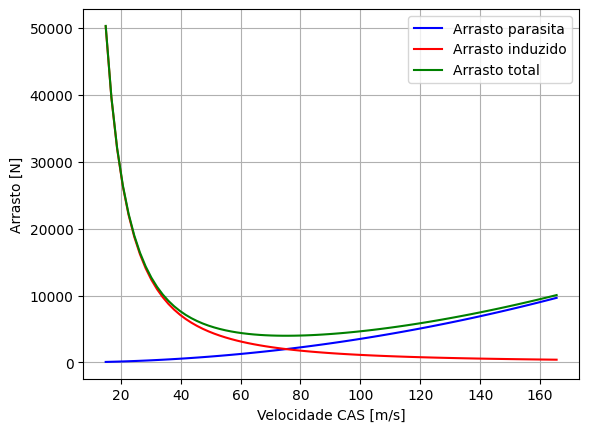

In [23]:
plt.figure()
plt.plot(vector_v, D_p, 'b', label='Arrasto parasita')
plt.plot(vector_v, D_i, 'r', label='Arrasto induzido')
plt.plot(vector_v, D_p + D_i, 'g', label='Arrasto total')
plt.xlabel('Velocidade CAS [m/s]')
plt.ylabel('Arrasto [N]')
plt.grid()
plt.legend()

# Escolha de motorização

Estimativa de arrasto (compor parasita e induzido) -> Traçar D x V -> Análise de constraints de performance -> Curva T/W x W/S -> define-se motor

1. Análise de constraints para:
- Decolagem
- Subida
- Teto máximo*
- Cruzeiro / curvas* / $V_{max}$*
- Pouso

* Notas do Gundmundsson

2. Escolha de T/W e W/S (3 valores)

3. Comparar/analisar W/S constraints com valores previamente estimados. Se necessário, corrigir valores!!

4. Com T/W, obter T, em HP, para o produto (3 valores) e selecionar o motor "comercial" que satisfaça os requisitos de projeto:
- Quanto à Potência / Tração
- Quanto ao peso
- Quanto à fixação na aeronave e volume instalado
- Quanto à economia/consumo de cobustível

5. Criar planilha / *dataframe* contendo dados do motor para análise de desempenho

## Análise de constraints

In [24]:
## Decolagem
beta_dec  = 0.97  #relação de peso na decolagem e peso nominal
K_dec     = 1.2   # relação V_dec/V_estol
alpha_dec = 1     # relação T_i/T_nominal
S_g_dec   = 700   # distância de decolagem
Cl_max    = 1.7   # verificar ClxAlpha
W_S_dec   = np.linspace(1000, 2500, 100)


T_W_dec = ((beta_dec**2 * K_dec**2)/(alpha_dec*9.81*S_g_dec*rho_SL*Cl_max))*(W_S_dec)
print(T_W_dec)

[0.09474448 0.09618    0.09761552 0.09905104 0.10048657 0.10192209
 0.10335761 0.10479313 0.10622865 0.10766418 0.1090997  0.11053522
 0.11197074 0.11340627 0.11484179 0.11627731 0.11771283 0.11914836
 0.12058388 0.1220194  0.12345492 0.12489045 0.12632597 0.12776149
 0.12919701 0.13063253 0.13206806 0.13350358 0.1349391  0.13637462
 0.13781015 0.13924567 0.14068119 0.14211671 0.14355224 0.14498776
 0.14642328 0.1478588  0.14929433 0.15072985 0.15216537 0.15360089
 0.15503641 0.15647194 0.15790746 0.15934298 0.1607785  0.16221403
 0.16364955 0.16508507 0.16652059 0.16795612 0.16939164 0.17082716
 0.17226268 0.17369821 0.17513373 0.17656925 0.17800477 0.17944029
 0.18087582 0.18231134 0.18374686 0.18518238 0.18661791 0.18805343
 0.18948895 0.19092447 0.19236    0.19379552 0.19523104 0.19666656
 0.19810209 0.19953761 0.20097313 0.20240865 0.20384417 0.2052797
 0.20671522 0.20815074 0.20958626 0.21102179 0.21245731 0.21389283
 0.21532835 0.21676388 0.2181994  0.21963492 0.22107044 0.22250

In [25]:
## Subida
beta_climb  = 0.955               # relação de peso na subida e peso total
alpha_climb = 0.9                 # relação de tração
Cd_0        = 0.0136
V_climb     = 1.8*aircraft['definitions']['V_stall']
q_climb     = 0.5*rho_SL*V_climb**2
K_climb     = 1*K                 # considerando Cl_climb = 1
dh_dt_climb = 10                  # [m/s] - razão de subida
W_S_climb   = np.linspace(1000, 2500, 100)

T_W_climb = (beta_climb/alpha_climb)*((Cd_0*q_climb/beta_climb)*(1/W_S_climb) + (beta_climb*K_climb/q_climb)*W_S_climb + ((dh_dt_climb)/(V_climb)))
print(T_W_climb)

[0.20760401 0.20706598 0.20654948 0.20605355 0.20557733 0.20511997
 0.2046807  0.20425876 0.20385347 0.20346414 0.20309015 0.2027309
 0.20238583 0.2020544  0.20173609 0.20143042 0.20113693 0.20085518
 0.20058474 0.20032523 0.20007625 0.19983744 0.19960846 0.19938898
 0.19917868 0.19897725 0.19878441 0.19859988 0.1984234  0.19825471
 0.19809356 0.19793973 0.19779299 0.19765313 0.19751993 0.19739321
 0.19727277 0.19715842 0.19705    0.19694733 0.19685025 0.1967586
 0.19667223 0.196591   0.19651477 0.1964434  0.19637676 0.19631473
 0.19625718 0.196204   0.19615508 0.1961103  0.19606956 0.19603276
 0.1959998  0.19597058 0.19594502 0.19592302 0.1959045  0.19588937
 0.19587755 0.19586897 0.19586355 0.19586121 0.19586189 0.19586551
 0.19587201 0.19588133 0.19589339 0.19590815 0.19592553 0.19594549
 0.19596797 0.1959929  0.19602025 0.19604995 0.19608196 0.19611623
 0.19615272 0.19619137 0.19623214 0.196275   0.19631989 0.19636677
 0.19641562 0.19646638 0.19651902 0.1965735  0.19662979 0.196687

In [26]:
## Cruzeiro
beta_cruz  =  0.87    # relação de peso no cruzeiro e peso total
alpha_cruz =  0.5     # relação de potência utilizada
Cd_0       =  0.041
q_cruz     =  0.5*rho*aircraft['definitions']['V_cruise']**2
K_cruz     =  0.5*K   # considerando Cl_cruz = 0.5
W_S_cruz   = np.linspace(1000, 2500, 100)

T_W_cruz = (beta_cruz/alpha_cruz)*((Cd_0*q_cruz/beta_cruz)*(1/W_S_cruz) + (beta_cruz*K_cruz/q_cruz)*W_S_cruz)
print(T_W_cruz)

[0.32294868 0.31837103 0.31393161 0.3096244  0.30544375 0.30138431
 0.29744102 0.29360911 0.28988407 0.28626162 0.28273771 0.27930851
 0.27597036 0.27271982 0.26955359 0.26646856 0.26346176 0.26053035
 0.25767164 0.25488307 0.2521622  0.24950668 0.24691428 0.24438289
 0.24191047 0.23949507 0.23713484 0.23482799 0.23257282 0.23036769
 0.22821106 0.22610141 0.2240373  0.22201737 0.22004027 0.21810475
 0.21620957 0.21435356 0.21253559 0.21075458 0.20900948 0.20729927
 0.20562301 0.20397973 0.20236856 0.20078862 0.19923908 0.19771912
 0.19622797 0.19476487 0.19332911 0.19191998 0.19053681 0.18917893
 0.18784572 0.18653657 0.18525088 0.18398808 0.18274762 0.18152896
 0.18033159 0.17915499 0.17799869 0.17686221 0.17574509 0.17464689
 0.17356718 0.17250555 0.17146158 0.17043489 0.16942509 0.16843182
 0.16745472 0.16649343 0.16554762 0.16461695 0.16370112 0.1627998
 0.1619127  0.16103952 0.16017997 0.15933378 0.15850067 0.15768039
 0.15687267 0.15607727 0.15529394 0.15452245 0.15376257 0.15301

In [27]:
## Pouso
beta_pouso =  0.853  # relação de peso no pouso e peso nominal
K_pouso    =  1.3    # relação V_pouso/V_estol
mi_pouso   =  0.3    # coeficiente de atrito
Cl_max     =  1.7    # verificar ClxAlpha
S_l_pouso  =  500   #[m] - distância desde um obstáculo a 15m de altura até a parada da aeronave

(W_S_pouso) = (S_l_pouso*9.81*mi_pouso*rho_SL*Cl_max)/(beta_pouso*K_pouso**2)

print(W_S_pouso)

2125.7370750909163


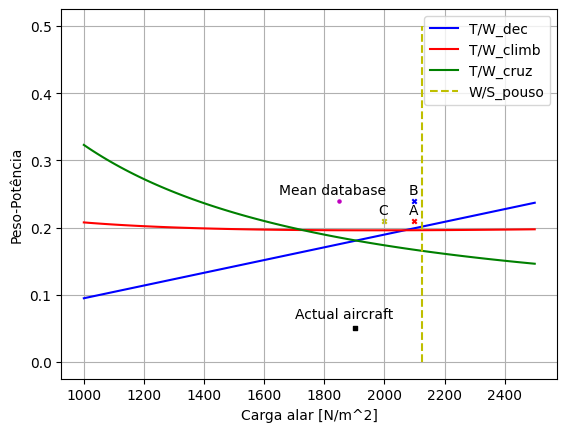

In [28]:
plt.figure()
# Plot constraints lines
plt.plot(W_S_dec, T_W_dec, 'b', label='T/W_dec')
plt.plot(W_S_climb, T_W_climb, 'r', label='T/W_climb')
plt.plot(W_S_cruz, T_W_cruz, 'g', label='T/W_cruz')
plt.vlines(W_S_pouso, 0, 0.5, 'y', linestyles= '--', label='W/S_pouso')
# Plot aircraft points
plt.scatter(aircraft['definitions']['wing_load'], aircraft['definitions']['Thrust_to_weight'], s=5,c='k', marker ='s')
plt.annotate('Actual aircraft', (aircraft['definitions']['wing_load']-200, aircraft['definitions']['Thrust_to_weight']+0.015))

plt.scatter(1850, 0.24, s=5,c='m', marker='o')
plt.annotate('Mean database', (1650, 0.25))
# Candidate points
plt.scatter(2100, 0.21, s=10,c='r', marker='x')
plt.annotate('A', (2100-20, 0.21+0.01))

plt.scatter(2100, 0.24, s=10,c='b', marker='x')
plt.annotate('B', (2100-20, 0.24+0.01))

plt.scatter(2000, 0.21, s=10,c='y', marker='x')
plt.annotate('C', (2000-20, 0.21+0.01))
# -----------------------------------------------
plt.xlabel('Carga alar [N/m^2]')
plt.ylabel('Peso-Potência')
plt.grid()
plt.legend(loc='upper right')

In [29]:
## Cálculo da tração dos motores
# T_W_final entre 0.21 e 0.24
eta_T = 0.65
T_W_i = 0.21
T_W_f = 0.24
T_1 = aircraft['definitions']['MTOW']*0.21
T_2 = aircraft['definitions']['MTOW']*0.24


print(T_1, T_2)

1809.8639999999998 2068.4159999999997


# Segunda estimativa de peso dos componentes

Em seguida, peso e balanceamento

# componentes:

* Fuselagem
* Asa
* H_t
* V_t
* Gmp(motores, helices, bercos, etc)
* trem de Pouso
* Comandos
* Aviônica
* sistemas(hidraulicos, eletricos, etc)
* Assentos e mobiliaro
* Ocupantes
* Bagagem
* Combustivel, etc

# Procedimento:

1.   Desenhar a aeronave em vista lateral(croqui)-escala
2.   Estimar o peso e C.G de cada Componente
3.   Localizar No Croqui
4.   Inserir



In [30]:
with open(r"weight_stimation_data.json", "r") as file:
    weight_estimation_data = json.load(file)

print(weight_estimation_data.keys())

def calculate_wing_weight(wing, materials, wing_structural_conditions_type):
    SW = wing['S']
    MAC = wing['CMA']
    tC = wing['thickness']
    density = materials[wing['material']]
    AR = wing['S']/(wing['b']**2)
    nult = wing['nult']
    sweep = wing['sweep']
    taper_ratio = wing['taper_ratio']

    K_p = weight_estimation_data["wing_structural_conditions"][wing_structural_conditions_type]

    W_w = (K_p * SW * MAC * (tC)**0.3 * density**0.5 * AR**0.7 * (nult**0.5) * (sweep)**0.3 * (taper_ratio)**0.4) / g
    return W_w

def calculate_horizontal_tail_weight(horizontal_tail, materials, factors, density_factors):
    SHT = horizontal_tail['SHT']
    MACHT = horizontal_tail['MACHT']
    tC_HT = horizontal_tail['tC_HT']
    density = materials[horizontal_tail['material']]
    ARHT = horizontal_tail['ARHT']
    sweepHT = horizontal_tail['sweepHT']
    taper_ratioHT = horizontal_tail['taper_ratioHT']
    Ce_CT = horizontal_tail['Ce_CT']
    VH = horizontal_tail['VH']
    g = factors['gravitational_constant']

    K_HT = density_factors['K_HT']

    W_HT = (K_HT * SHT * MACHT * (tC_HT)**0.3 * density**0.5 * ARHT**0.7 * (sweepHT)**0.3 * (taper_ratioHT)**0.4 * Ce_CT * VH) / g
    return W_HT

FileNotFoundError: [Errno 2] No such file or directory: '/content/weight_estimation_data.json'

# Estabilidade e controle

# Parâmetros de desempenho

Efetuar cálculos das seguintes etapas da missão:

1) Decolagem
2) Subida
3) Cruzeiro
4) Descida
5) Loiter
6) Pouso
7) Curvas

As funções para as análises dessas etapas de voo foram implementadas em script separado.

O código implementa o cálculo da distância de decolagem de uma aeronave, dividindo o processo em três fases: aceleração, transição e subida. A seguir, descrevo brevemente as deduções das fórmulas usadas em cada fase.

Nesta fase, a aeronave acelera da velocidade inicial $V_i$ até a velocidade final $V_f$ na pista.

1. **Força resultante e aceleração**:
    - A força resultante é dada por $ M \cdot a(t) = T - D - \mu \cdot (W - L) $
    - Onde $a(t)$ é a aceleração, $T$ é a tração, $D$ é o arrasto, $\mu$ é o coeficiente de atrito, $W$ é o peso, e $L$ é a sustentação.
    - Substituindo $D$ e $L$ pelas suas expressões aerodinâmicas, temos:
    $$
    a(t) = g \left[ \left( \frac{T}{W} - \mu \right) - \left( \frac{\rho}{W/S} \right) \left( C_{D0} + K \cdot C_L^2 - \mu \cdot C_L \right) V^2 \right]
    $$
    - Onde $ K = \frac{1}{\pi \cdot AR \cdot e} $.

2. **Integração da aceleração para obter a distância de decolagem**:
    - A distância $s(t)$ é obtida pela integração da velocidade em função da aceleração:
    $$
    s(t) = \int_{V_i}^{V_f} \frac{V}{a} dV \approx \frac{1}{2gKA} \ln \left( \frac{KT + KA \cdot V_f^2}{KT + KA \cdot V_i^2} \right)
    $$
    - Onde $KT = \frac{T}{W} - \mu$ e $KA = \frac{\rho}{W/S} \left( C_{D0} + K \cdot C_L^2 - \mu \cdot C_L \right)$.

Nesta fase, a aeronave transita da corrida de decolagem para o início da subida.

1. **Cálculo do raio de curvatura ($R$) e altura de transição ($h_R$)**:
    - Definindo $n = 1.2$, temos:
    $$
    R = \frac{(1.2 \cdot V_{stall})^2}{g \cdot (n - 1)}
    $$
    $$
    h_R = R \cdot (1 - \cos(\gamma))
    $$

2. **Distância de transição ($ST$)**:
    - A distância $ST$ é a hipotenusa do triângulo formado pela altura $h_R$ e o raio $R$:
    $$
    ST = \sqrt{R^2 - (R - h_R)^2}
    $$

Nesta fase, a aeronave sobe para superar um obstáculo.

1. **Distância de subida ($SC$)**:
    - A distância de subida é calculada usando a altura do obstáculo e o ângulo de subida:
    $$
    SC = \frac{h_{obstacle} - h_R}{\tan(\gamma)}
    $$


# Síntese de todas as características da aeronave

Usando este ambiente para não precisar rodar células específicas, pois já se encontra no final do projeto

In [ ]:
print(json.dumps(aircraft, indent = 2))

# Relações úteis sem uma seão específica ainda

Achei muita coisa útil no Gudmundsson, e pra não ter que ficar caçando toda vez, vou colocando aqui.

Modelo de decolagem:

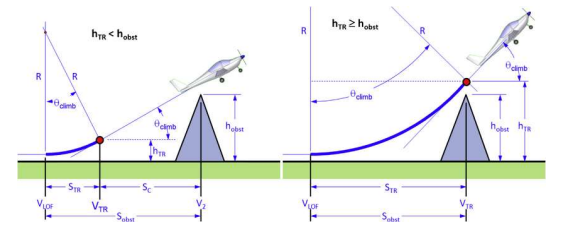

**Legenda:**

* $h_{tr}$: Altura total
* $h_{obut}$: Altura inicial
* $h_{TR}$: Altura final
* $R$: Raio da trajetória
* $e_{cimb}$: Energia cinética de subida
* $\theta_{cfrob}$: Ângulo de descida
* $h_{vhst}$: Altura da pista de pouso
* $h_{chut}$: Altura da chuteira
* $h_{n}$: Altura final
* $S_{m}$: Distância percorrida na fase de subida
* $S$: Distância total percorrida
* $S_{re}$: Distância percorrida na fase de descida
* $VTR$: Velocidade terminal
* $S_{\_hot}$: Distância horizontal percorrida
* Sabit: Constante


$V_{TR}$ = velocidade de transição = 1.15 $V_{stall}$
$V_{LOF}$ = velocidade de Lift off = 1.1 $V_{stall}$

$V_v$ = Velocidade vertical = V sin$\theta$ = $\dfrac{TV - DV}{W}$

$sin\theta = \dfrac{T}{W} - \dfrac{1}{L/D}$

